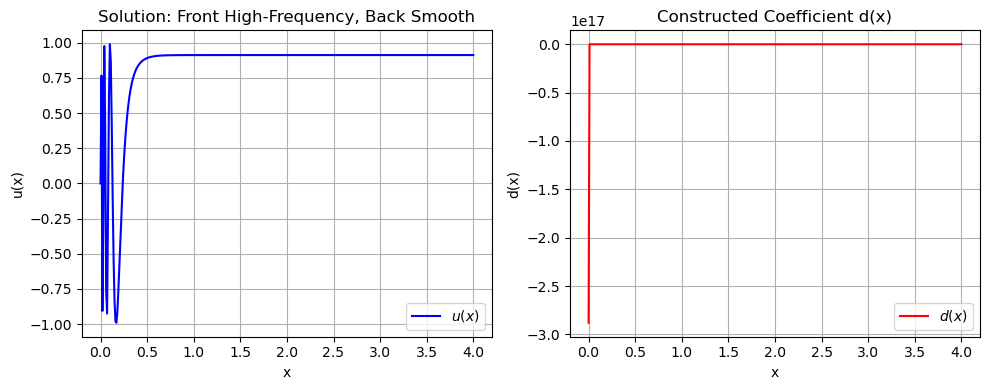

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==== 1. Parameters ====
C = 20.0    # Controls the initial "wave number" (larger C -> higher oscillations near x=0)
k = 12.0    # Controls decay speed (larger k -> faster transition to smoothness)
L = 4.0    # Domain [0, L]

# ==== 2. Define functions ====

def theta(x):
    """Phase function θ(x) = C(1 - exp(-k*x))"""
    return C * (1 - np.exp(-k*x))

def u_function(x):
    """Solution u(x) = sin(theta(x))"""
    return np.sin(theta(x))

def d_function(x):
    """Coefficient d(x) computed from u''(x)/u(x)"""
    t = theta(x)
    st = np.sin(t)
    ct = np.cos(t)
    dt1 = C * k * np.exp(-k*x)       # θ'(x)
    dt2 = -C * (k**2) * np.exp(-k*x) # θ''(x)
    
    u_xx = -st * (dt1**2) + ct * dt2
    
    return u_xx / (st + 1e-14)  # small value to avoid division by zero

# ==== 3. Discretize domain and compute ====

N = 400
x_vals = np.linspace(0, L, N)
u_vals = np.zeros_like(x_vals)
d_vals = np.zeros_like(x_vals)

for i, x in enumerate(x_vals):
    u_vals[i] = u_function(x)
    d_vals[i] = d_function(x)

# ==== 4. Plot the results ====

plt.figure(figsize=(10,4))

# (a) Plot u(x)
plt.subplot(1,2,1)
plt.plot(x_vals, u_vals, 'b', label=r'$u(x)$')
plt.title('Solution: Front High-Frequency, Back Smooth')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()

# (b) Plot d(x)
plt.subplot(1,2,2)
plt.plot(x_vals, d_vals, 'r', label=r'$d(x)$')
plt.title('Constructed Coefficient d(x)')
plt.xlabel('x')
plt.ylabel('d(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
import jax
import jax.numpy as jnp
import os,sys
# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from model.fbpinn_model import FBPINN   # 与项目里的路径保持一致

# --------- problem definition ------------------------------------------------
L = 4.0                  # 物理区间 [0, L]

C = 20.0                 # theta(x) = C(1-e^{-k x})
k = 12.0

def theta(x):
    return C * (1.0 - jnp.exp(-k * x))

def d_function(x):
    """
    由 u = sin(theta(x)) 反推得到的 d(x)
    公式推导见上一条回复
    """
    t  = theta(x)
    st = jnp.sin(t)
    ct = jnp.cos(t)
    dt1 = C * k * jnp.exp(-k * x)
    dt2 = -C * k**2 * jnp.exp(-k * x)
    u_xx = -st * dt1**2 + ct * dt2
    # 避免除 0
    return u_xx / (st + 1e-14)

def u_exact(x):
    """仅供可视化 / 验证，不参与训练"""
    return jnp.sin(theta(x))

# --------- network hard-constraint (ansatz) ----------------------------------
def ansatz(x, nn_out):
    """
    用 tanh(k*x) 保证 u(0)=0，但不固定 x=L 处值，
    这样网络可以自由拟合右端边界。
    """
    return x * nn_out

# --------- PDE residual for FBPINN ------------------------------------------
def pde_residual_loss(model: FBPINN, subdomain_collocation_points):
    """
    对所有子域 collocation 点一次性计算：
        residual(x) = -u_xx(x) + d(x) * u(x)
    并取全局 MSE。
    """
    # 把各子域 collocation 点拼成一维数组
    x_all = jnp.concatenate(subdomain_collocation_points, axis=0)   # [N_pts]

    # 标量函数 u(x) 供自动微分
    def u_func(x):
        return model.total_solution(x).squeeze()    # -> scalar

    # 二阶导：vmap ∘ grad ∘ grad   （也可用 hessian）
    u_xx_all = jax.vmap(lambda xx: jax.grad(jax.grad(u_func))(xx))(x_all)
    print(u_xx_all.shape)
    u_all    = jax.vmap(u_func)(x_all)
    print(u_all.shape)
    d_all    = jax.vmap(d_function)(x_all)
    print(d_all.shape)

    residual = -u_xx_all + d_all * u_all
    return jnp.mean(residual**2)


In [35]:
import os
import sys
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
import importlib



from utils.data_utils import generate_subdomain, generate_collocation_points
from utils.window_function import my_window_func
from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
#import physics.pde_phi_sin as pde_module


# Training hyperparameters
steps = 10000
lr = 1e-3
n_sub = 5
overlap = 0.5
n_points_per_subdomain = 200
#ckpt_every = 2000
#save_dir = "outputs/demo_fbpinn"

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 16,
    "depth": 2,
    "activation": jax.nn.tanh,
}
domain = [1e-3,L]

In [36]:
# generate uniform subdomains, n_sub = 5, overlap = 2

subdomains_list = generate_subdomain(domain=domain,n_sub=n_sub,overlap=overlap)
print(subdomains_list)

[(-0.24900001287460327, 1.050800085067749), (0.5508000254631042, 1.850600004196167), (1.350600004196167, 2.650399923324585), (2.150400161743164, 3.450200080871582), (2.950200080871582, 4.25)]


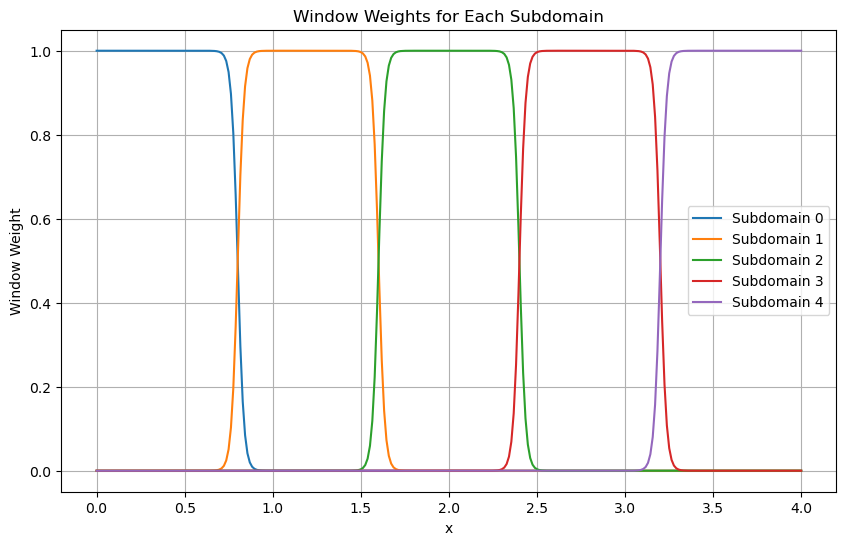

In [37]:
# illustration of window function
x_test = jnp.linspace(0, L, 300)
window_weights_1 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_1.shape[1]):
    plt.plot(x_test, window_weights_1[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [38]:
key = jax.random.PRNGKey(42)
model = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list,  
    mlp_config=mlp_config
)

In [39]:
subdomain_collocation_points, global_collocation_points = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

Subdomain [-0.25, 1.05]: 253 points
Subdomain [0.55, 1.85]: 337 points
Subdomain [1.35, 2.65]: 336 points
Subdomain [2.15, 3.45]: 330 points
Subdomain [2.95, 4.25]: 251 points


In [40]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model, train_loss, (test_steps, test_l1) = train_fbpinn(
    model=model,
    subdomain_collocation_points=subdomain_collocation_points,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

(1507,)
(1507,)
(1507,)
[FBPINN] Step=0, Loss=4.636e+03, L1=8.7824e-01
[FBPINN] Step=1000, Loss=2.708e-01, L1=8.6512e-01
[FBPINN] Step=2000, Loss=7.106e-02, L1=8.6534e-01
[FBPINN] Step=3000, Loss=1.423e-02, L1=8.6609e-01
[FBPINN] Step=4000, Loss=1.265e-01, L1=8.7165e-01
[FBPINN] Step=5000, Loss=2.431e-01, L1=8.7779e-01
[FBPINN] Step=6000, Loss=3.705e-03, L1=8.8492e-01
[FBPINN] Step=7000, Loss=9.230e-03, L1=8.8924e-01
[FBPINN] Step=8000, Loss=1.055e-02, L1=8.9451e-01
[FBPINN] Step=9000, Loss=2.693e-02, L1=9.0226e-01
[FBPINN] Step=9999, Loss=1.473e-02, L1=9.0867e-01


In [41]:
# Plot
u_pred = jax.vmap(model)(x_test)
u_true = u_exact(x_test)

In [42]:
def plot_fbpinn_summary(x_test, u_true, u_pred,
                                  train_loss, test_steps, test_l1,
                                  model):
    """Display all core visualizations in one figure (Jupyter-friendly)."""

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # 1. Prediction vs Exact
    axs[0].plot(x_test, u_pred, label="Predicted")
    axs[0].plot(x_test, u_true, "--", label="Exact")
    axs[0].set_title("Prediction vs Exact")
    axs[0].legend()
    axs[0].grid(True)

    # 2. Training loss
    axs[1].plot(train_loss, label="Train Loss")
    axs[1].set_title("Training Loss (Log Scale)")
    axs[1].set_yscale("log")
    axs[1].legend()
    axs[1].grid(True)

    # 3. L1 error curve
    axs[2].plot(test_steps, test_l1, label="L1 Error")
    axs[2].set_title("Test L1 Error Curve")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("L1")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Subdomain partials
    n_sub = len(model.subnets)
    for i in range(n_sub):
        partial_solution_i = jax.vmap(lambda x: model.subdomain_pred(i, x))(x_test).squeeze()
        window_i = model.subdomain_window(i, x_test)
        weighted = model.ansatz(x_test, window_i * partial_solution_i)
        axs[3].plot(x_test, weighted, label=f"Subdomain {i}", alpha=0.6)
    axs[3].plot(x_test, u_true, "--", color="black", label="Exact", linewidth=2)
    axs[3].set_title("Subdomain Partial Predictions")
    axs[3].legend(fontsize=8, ncol=2)
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


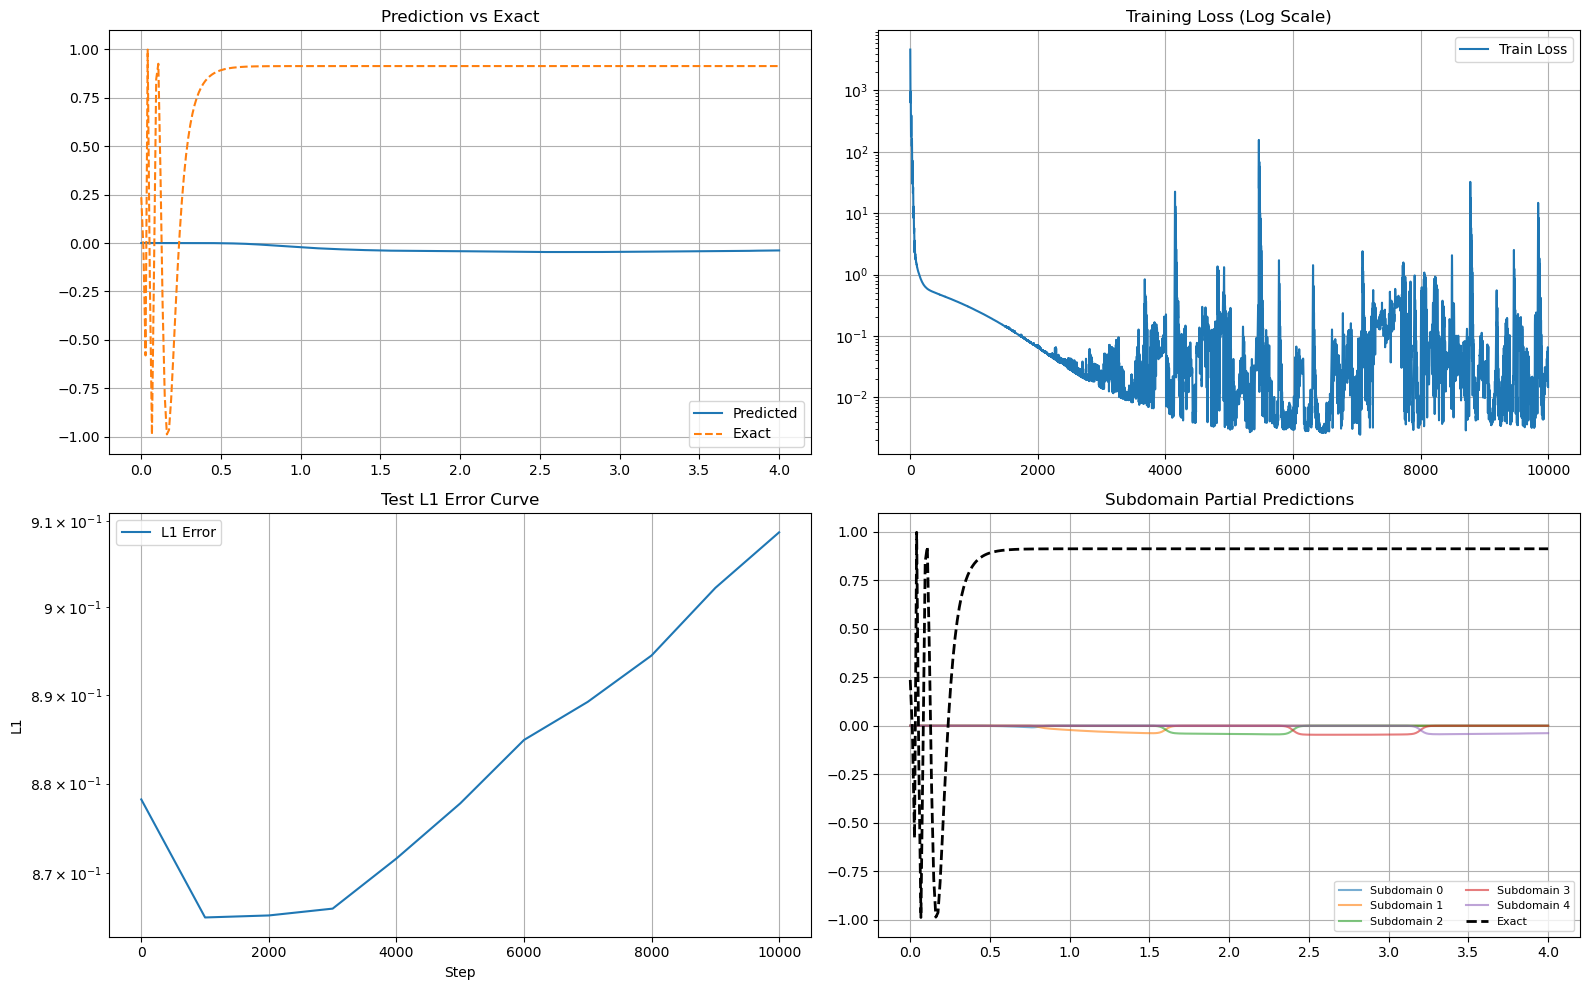

In [43]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred,
    train_loss=train_loss,
    test_steps=test_steps,
    test_l1=test_l1,
    model=model
)


In [88]:
subdomains_list_defined = [
    (0.00, 0.10),
    (0.05, 0.20),
    (0.15, 0.30),
    (0.25, 0.45),
    (0.40, 0.60),
    (0.55, 0.80),
    (0.70, 4.00)
]

subdomain_collocation_points_defined, global_collocation_points_defined = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list_defined,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)


Subdomain [0.00, 0.10]: 44 points
Subdomain [0.05, 0.20]: 48 points
Subdomain [0.15, 0.30]: 52 points
Subdomain [0.25, 0.45]: 70 points
Subdomain [0.40, 0.60]: 71 points
Subdomain [0.55, 0.80]: 83 points
Subdomain [0.70, 4.00]: 1148 points


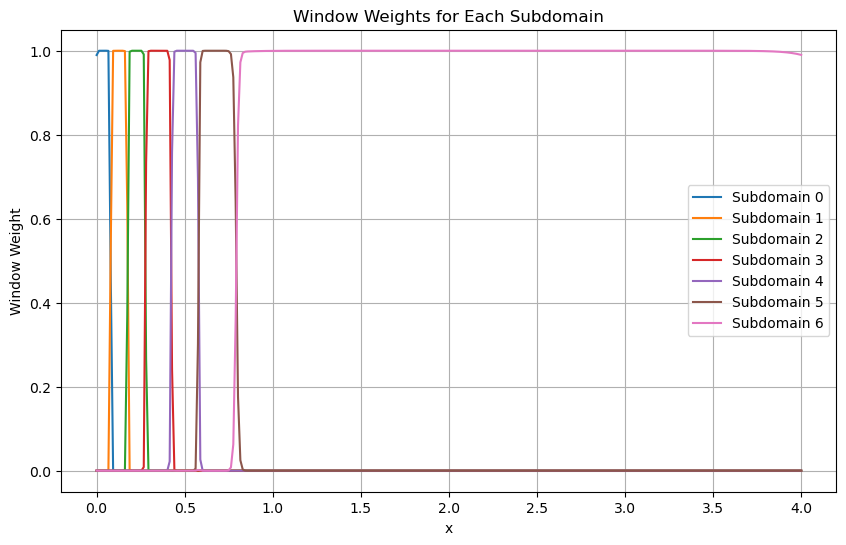

In [89]:
# illustration of window function
x_test = jnp.linspace(0, 4, 300)
window_weights = my_window_func(subdomains_list_defined, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights.shape[1]):
    plt.plot(x_test, window_weights[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [90]:
key = jax.random.PRNGKey(42)
model_2 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list_defined,  
    mlp_config=mlp_config
)

In [91]:
steps=10000
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_2, train_loss_2, (test_steps, test_l1_2) = train_fbpinn(
    model=model_2,
    subdomain_collocation_points=subdomain_collocation_points_defined,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

[FBPINN] Step=0, Loss=7.304e+05, L1=8.7501e-01
[FBPINN] Step=1000, Loss=2.332e+01, L1=8.7373e-01
[FBPINN] Step=2000, Loss=8.100e+00, L1=8.7465e-01
[FBPINN] Step=3000, Loss=2.947e+00, L1=8.7563e-01
[FBPINN] Step=4000, Loss=1.493e+00, L1=8.7624e-01
[FBPINN] Step=5000, Loss=1.367e+00, L1=8.7656e-01
[FBPINN] Step=6000, Loss=2.166e+00, L1=8.7665e-01
[FBPINN] Step=7000, Loss=2.006e+00, L1=8.7662e-01
[FBPINN] Step=8000, Loss=3.198e+00, L1=8.7657e-01
[FBPINN] Step=9000, Loss=8.061e-01, L1=8.7655e-01
[FBPINN] Step=9999, Loss=3.963e-01, L1=8.7650e-01


In [93]:
# Plot
u_pred_defined = jax.vmap(model_2)(x_test)
u_true = u_exact(x_test)

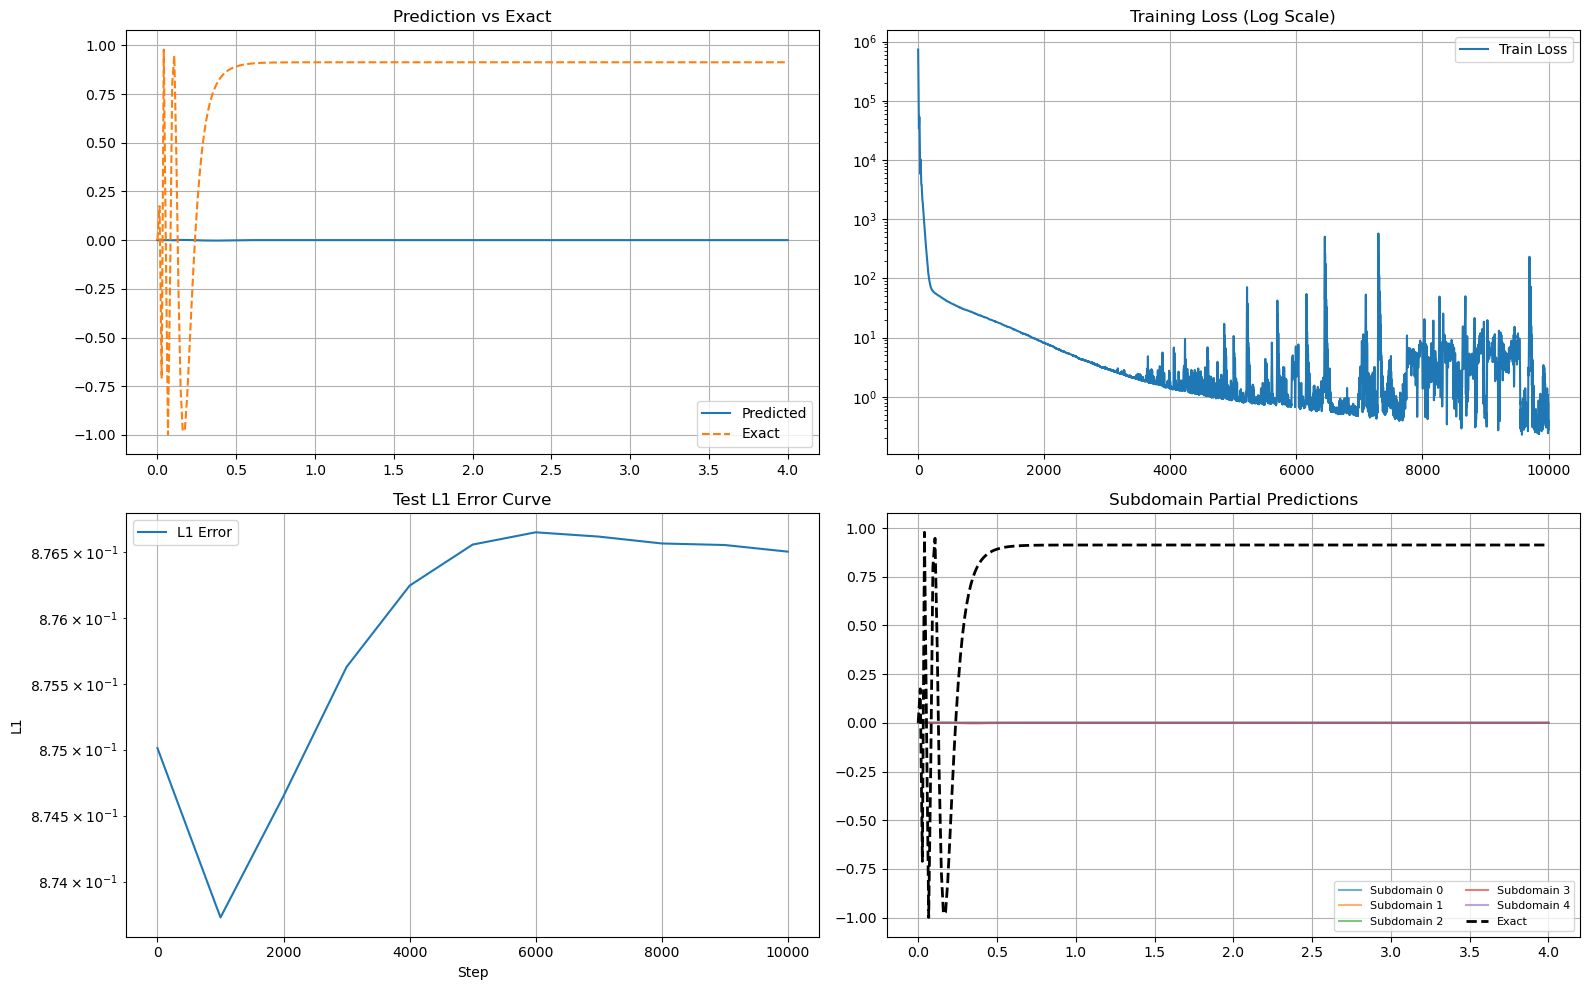

In [94]:
def plot_fbpinn_summary(x_test, u_true, u_pred_defined,
                                  train_loss_2, test_steps, test_l1_2,
                                  model_2):
    """Display all core visualizations in one figure (Jupyter-friendly)."""

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # 1. Prediction vs Exact
    axs[0].plot(x_test, u_pred_defined, label="Predicted")
    axs[0].plot(x_test, u_true, "--", label="Exact")
    axs[0].set_title("Prediction vs Exact")
    axs[0].legend()
    axs[0].grid(True)

    # 2. Training loss
    axs[1].plot(train_loss_2, label="Train Loss")
    axs[1].set_title("Training Loss (Log Scale)")
    axs[1].set_yscale("log")
    axs[1].legend()
    axs[1].grid(True)

    # 3. L1 error curve
    axs[2].plot(test_steps, test_l1_2, label="L1 Error")
    axs[2].set_title("Test L1 Error Curve")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("L1")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Subdomain partials
    n_sub = len(model_2.subnets)
    for i in range(n_sub):
        partial_solution_i = jax.vmap(lambda x: model_2.subdomain_pred(i, x))(x_test).squeeze()
        window_i = model_2.subdomain_window(i, x_test)
        weighted = model_2.ansatz(x_test, window_i * partial_solution_i)
        axs[3].plot(x_test, weighted, label=f"Subdomain {i}", alpha=0.6)
    axs[3].plot(x_test, u_true, "--", color="black", label="Exact", linewidth=2)
    axs[3].set_title("Subdomain Partial Predictions")
    axs[3].legend(fontsize=8, ncol=2)
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred_defined=u_pred_defined,
    train_loss_2=train_loss_2,
    test_steps=test_steps,
    test_l1_2=test_l1_2,
    model_2=model_2
)
